In [78]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
import pylab as py
import scipy.stats as stats 
from scipy.stats import norm, skew, probplot
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [2]:
year = ['2011','2012','2013','2014','2015','2016','2017','2018']
data_ = pd.DataFrame()

acs = pd.read_csv("../data/ACS_2011.csv")
acs['year'] = 2011

pp = pd.read_csv("../data/ACS_2012.csv")
pp['year'] = 2012
acs = acs.append(pp)

pp = pd.read_csv("../data/ACS_2013.csv")
pp['year'] = 2013
acs = acs.append(pp)

pp = pd.read_csv("../data/ACS_2014.csv")
pp['year'] = 2014
acs = acs.append(pp)

pp = pd.read_csv("../data/ACS_2015.csv")
pp['year'] = 2015
acs = acs.append(pp)

pp = pd.read_csv("../data/ACS_2016.csv")
pp['year'] = 2016
acs = acs.append(pp)

pp = pd.read_csv("../data/ACS_2017.csv")
pp['year'] = 2017
acs = acs.append(pp)

pp = pd.read_csv("../data/ACS_2018.csv")
pp['year'] = 2018
data_ = acs.append(pp)

In [3]:
zir = pd.read_csv("../data/Zip_Zri_MultiFamilyResidenceRental.csv")

In [4]:
data_['geo_id'] = data_['geo_id'].astype(str).str.zfill(5)
zir['RegionName'] = zir['RegionName'].astype(str).str.zfill(5)

In [5]:
cols_replace = list(zir.columns)[7:]
cols_keep = list(zir.columns)[:7]
zil_new = zir.melt(id_vars=cols_keep, value_vars = cols_replace)
zil_new['variable']= pd.to_datetime(zil_new['variable'])

In [6]:
zil_new['year'] = zil_new['variable'].apply(lambda a: a.year)
zil_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210293 entries, 0 to 210292
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   RegionID    210293 non-null  int64         
 1   RegionName  210293 non-null  object        
 2   City        210293 non-null  object        
 3   State       210293 non-null  object        
 4   Metro       209954 non-null  object        
 5   CountyName  210293 non-null  object        
 6   SizeRank    210293 non-null  int64         
 7   variable    210293 non-null  datetime64[ns]
 8   value       140035 non-null  float64       
 9   year        210293 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 16.0+ MB


In [7]:
zil_yr = zil_new.groupby(['RegionName', 'year']).mean().reset_index()
zil_yr.drop(['SizeRank','RegionID'], inplace=True, axis=1)

In [8]:
zil_targets = zil_yr[zil_yr['year'] > 2011]
zil_targets = zil_targets[zil_targets['year'] < 2020]
zil_targets.head(50)

,RegionName,year,value
2,01013,2012,943.416667
3,01013,2013,923.583333
4,01013,2014,936.083333
5,01013,2015,962.166667
6,01013,2016,1030.333333
7,01013,2017,1065.916667
8,01013,2018,1139.416667
9,01013,2019,1132.750000
13,01020,2012,937.166667
14,01020,2013,929.083333


In [9]:
zil_yr = zil_yr.dropna()
zil_targets = zil_yr[zil_yr['year'] > 2011]
zil_yr = zil_yr[zil_yr['year'] > 2010]
zil_yr = zil_yr[zil_yr['year'] < 2019]

In [10]:
df_final = zil_yr.merge(data_, how='left', left_on = ['RegionName','year'], right_on=['geo_id', 'year'])

In [11]:
df_final.drop(['pop_5_years_over', 'speak_only_english_at_home', 'speak_spanish_at_home_low_english', 
               'pop_15_and_over', 'pop_never_married', 'pop_now_married', 'pop_separated', 'pop_widowed',
              'pop_divorced', 'geoid','speak_spanish_at_home'], axis=1, inplace=True)

In [12]:
df_final[df_final['geo_id'].isnull()]

,RegionName,year,value,geo_id,nonfamily_households,family_households,median_year_structure_built,rent_burden_not_computed,rent_over_50_percent,rent_40_to_50_percent,...,less_one_year_college,masters_degree,one_year_more_college,pop_25_years_over,commute_35_44_mins,commute_60_more_mins,commute_less_10_mins,commuters_16_over,hispanic_any_race,do_date
2509,11249,2011,2349.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2510,11249,2012,2690.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2511,11249,2013,2953.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2512,11249,2014,2964.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2513,11249,2015,3015.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2514,11249,2016,3109.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2515,11249,2017,3066.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2516,11249,2018,2902.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7184,75033,2016,1372.555556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7185,75033,2017,1564.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_final = df_final[df_final['RegionName']!='11249']
df_final = df_final[df_final['RegionName']!='75033']

df_final[df_final['geo_id'].isnull()]

,RegionName,year,value,geo_id,nonfamily_households,family_households,median_year_structure_built,rent_burden_not_computed,rent_over_50_percent,rent_40_to_50_percent,...,less_one_year_college,masters_degree,one_year_more_college,pop_25_years_over,commute_35_44_mins,commute_60_more_mins,commute_less_10_mins,commuters_16_over,hispanic_any_race,do_date


In [14]:
null_zip = list(zip(df_final.columns, list(df_final.isnull().sum())))
non_zero = []
col_names = []
for i, j in null_zip:
    if j>0:
        non_zero.append(j)
        col_names.append(i)
list(zip(col_names, non_zero))

[('aggregate_travel_time_to_work', 28),
 ('owner_occupied_housing_units_lower_value_quartile', 3),
 ('owner_occupied_housing_units_median_value', 1),
 ('owner_occupied_housing_units_upper_value_quartile', 1),
 ('male_60_61', 1639),
 ('male_62_64', 1639),
 ('white_including_hispanic', 1639),
 ('black_including_hispanic', 1639),
 ('amerindian_including_hispanic', 1639),
 ('asian_including_hispanic', 1639),
 ('commute_5_9_mins', 1639),
 ('commute_35_39_mins', 1639),
 ('commute_40_44_mins', 1639),
 ('commute_60_89_mins', 1639),
 ('commute_90_more_mins', 1639),
 ('households_retirement_income', 1639),
 ('associates_degree', 874),
 ('bachelors_degree', 874),
 ('high_school_diploma', 874),
 ('less_one_year_college', 874),
 ('masters_degree', 874),
 ('one_year_more_college', 874),
 ('pop_25_years_over', 874)]

In [15]:
df_final[df_final[col_names].isnull().any(axis=1)][col_names]

df_final_sorted = df_final.sort_values(by=['RegionName', 'year'])

In [16]:
null_2011 = ['associates_degree', 'bachelors_degree', 
             'high_school_diploma', 
             'less_one_year_college', \
             'masters_degree', 
             'one_year_more_college', 
             'pop_25_years_over']

null_2018 = ['white_including_hispanic', 'black_including_hispanic', 
             'amerindian_including_hispanic', 
             'asian_including_hispanic', 
             'commute_5_9_mins', 'commute_35_39_mins', 
             'commute_40_44_mins', 'commute_60_89_mins', 
             'commute_90_more_mins', 'households_retirement_income',
            'male_60_61','male_62_64']

for i in range(0, df_final_sorted.shape[0]):
    if df_final_sorted['year'].iloc[i] == 2011:
        for j in range(0,len(null_2011)):
            df_final_sorted[null_2011[j]].iloc[i] = df_final_sorted[null_2011[j]].iloc[i+1]
    if df_final_sorted['year'].iloc[i] == 2018:
        for j in range(0,len(null_2018)):
            df_final_sorted[null_2018[j]].iloc[i] = df_final_sorted[null_2018[j]].iloc[i-1]


/Users/benburkey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [17]:
df_final = df_final_sorted.loc[:, df_final_sorted.columns != 'do_date']
df_final = df_final.dropna()

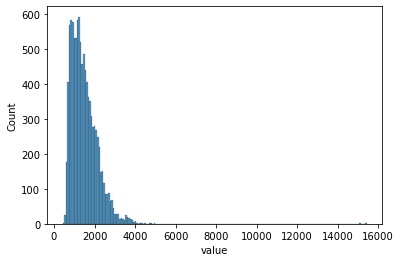

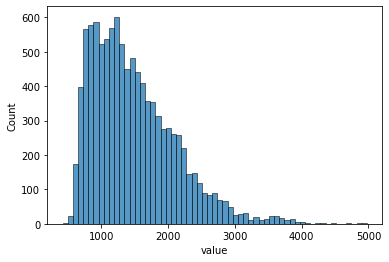

In [18]:
sns.histplot(x = 'value', data = df_final)
plt.show()
df_final = df_final[df_final['value'] < 6000]
sns.histplot(x = 'value', data = df_final)
plt.show()

In [19]:
# Filter Cityies with less than 100,000 people
zil_city = df_final.merge(zir, on = 'RegionName', how = 'left')
zil_city = zil_city[['RegionName','City','total_pop','year']]
zil_city = zil_city[zil_city['year'] == 2018]
zil_city.drop('year', inplace = True, axis= 1)
zil_city = zil_city.groupby('City').sum('total_pop').sort_values(by = 'total_pop')

zil_filter = zil_city[zil_city['total_pop'] >= 100000].reset_index()
zil_filter = zil_filter['City']

In [20]:
df_filtered = df_final.merge(zir[['RegionName','City']], on = 'RegionName', how = 'left')

df_filtered = df_filtered[df_filtered['City'].isin(zil_filter)]

## Cluster on three features

In [21]:
df_small_fil = df_filtered[['value']] #, 'total_pop', 'median_income']]
df_small_fil

,value
34,946.100000
35,972.583333
36,1058.666667
37,1129.166667
38,1125.083333
...,...
10246,979.000000
10247,995.833333
10248,1036.166667
10249,1154.833333


In [22]:
scaler = StandardScaler().fit(df_small_fil)
features = scaler.transform(df_small_fil)
df_scal = pd.DataFrame(features, columns = df_small_fil.columns)


In [23]:
columns = df_small_fil.columns
kmeans = KMeans(n_clusters = 3)
y = kmeans.fit_predict(df_small_fil[columns])
   
df_filtered['Cluster'] = y

## Add CPI data

In [24]:
year = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

cpi = [251.645, 257.081, 263.050, 270.509, 278.802, 288.233, 297.808, 307.660]
cpi_df = pd.DataFrame()
cpi_df['year'] = year
cpi_df['cpi'] = cpi
cpi_df

,year,cpi
0,2011,251.645
1,2012,257.081
2,2013,263.050
3,2014,270.509
4,2015,278.802
5,2016,288.233
6,2017,297.808
7,2018,307.660


In [25]:
df_addition = df_filtered.merge(cpi_df, how = 'left', on = 'year')

## Add GDP Growth (%) data

In [26]:
# Add GDP Growth (%)
year = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

gdp = [1.5508, 2.2495, 1.8421, 2.526, 3.0755, 1.7114, 2.3327, 2.9965]
gdp_df = pd.DataFrame()
gdp_df['year'] = year
gdp_df['gdp'] = gdp
gdp_df

,year,gdp
0,2011,1.5508
1,2012,2.2495
2,2013,1.8421
3,2014,2.5260
4,2015,3.0755
5,2016,1.7114
6,2017,2.3327
7,2018,2.9965


In [27]:
df_addition = df_addition.merge(gdp_df, how = 'left', on = 'year')

## Add Fed Interest Rate data

In [28]:
# Add Federal Interest Rate data
year = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

interest = [0.1016666667, 0.14, 0.1075, 0.08916666667, 0.1325, 0.395, 
            0.655, 1.42]
interest_df = pd.DataFrame()
interest_df['year'] = year
interest_df['interest'] = interest
interest_df

,year,interest
0,2011,0.101667
1,2012,0.140000
2,2013,0.107500
3,2014,0.089167
4,2015,0.132500
5,2016,0.395000
6,2017,0.655000
7,2018,1.420000


In [29]:
df_addition = df_addition.merge(interest_df, how = 'left', on = 'year')
df_addition

,RegionName,year,value,geo_id,nonfamily_households,family_households,median_year_structure_built,rent_burden_not_computed,rent_over_50_percent,rent_40_to_50_percent,...,commute_35_44_mins,commute_60_more_mins,commute_less_10_mins,commuters_16_over,hispanic_any_race,City,Cluster,cpi,gdp,interest
0,01104,2014,946.100000,01104,3346.0,5526.0,1949.0,158.0,1597.0,523.0,...,274.0,373.0,1215.0,8509.0,11849.0,Springfield,0,270.509,2.5260,0.089167
1,01104,2015,972.583333,01104,3377.0,5407.0,1948.0,146.0,1791.0,466.0,...,267.0,440.0,1582.0,9057.0,12909.0,Springfield,0,278.802,3.0755,0.132500
2,01104,2016,1058.666667,01104,3432.0,5434.0,1949.0,172.0,1898.0,516.0,...,291.0,418.0,1570.0,8844.0,13253.0,Springfield,0,288.233,1.7114,0.395000
3,01104,2017,1129.166667,01104,3287.0,5702.0,1946.0,107.0,2032.0,577.0,...,287.0,338.0,1635.0,8829.0,14100.0,Springfield,0,297.808,2.3327,0.655000
4,01104,2018,1125.083333,01104,3478.0,5599.0,1946.0,75.0,1963.0,502.0,...,271.0,364.0,1664.0,8918.0,14439.0,Springfield,0,307.660,2.9965,1.420000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6067,98499,2014,979.000000,98499,5610.0,6870.0,1973.0,265.0,2355.0,952.0,...,583.0,958.0,1375.0,12481.0,6395.0,Lakewood,0,270.509,2.5260,0.089167
6068,98499,2015,995.833333,98499,5736.0,6891.0,1973.0,346.0,2355.0,816.0,...,630.0,1105.0,1502.0,12735.0,6862.0,Lakewood,0,278.802,3.0755,0.132500
6069,98499,2016,1036.166667,98499,5670.0,6965.0,1973.0,310.0,2352.0,995.0,...,596.0,1285.0,1537.0,12984.0,6444.0,Lakewood,0,288.233,1.7114,0.395000
6070,98499,2017,1154.833333,98499,5149.0,7244.0,1973.0,327.0,2367.0,1006.0,...,611.0,1445.0,1400.0,12993.0,6260.0,Lakewood,0,297.808,2.3327,0.655000


## Add Census business data

In [30]:
bus_count = pd.read_csv('../data/bus_count.csv')

In [31]:
bus_count['zip'] = bus_count['zip'].astype(str).str.zfill(5)
bus_count

,zip,est,year
0,00501,2,2011
1,01001,436,2011
2,01002,558,2011
3,01003,16,2011
4,01004,19,2011
...,...,...,...
307187,99926,12,2018
307188,99928,5,2018
307189,99929,96,2018
307190,99950,16,2018


In [32]:
df_addition = df_addition.merge(bus_count, how = 'left', left_on = ['RegionName', 'year'], right_on = ['zip', 'year'])

# Feature Engineering

<AxesSubplot:>

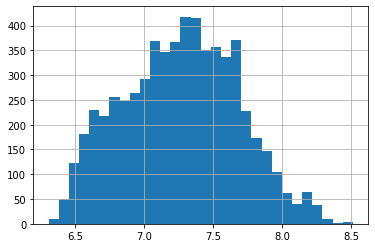

In [33]:
df_addition['log_value'] = np.log(df_addition['value'])
df_addition['log_value'].hist(bins=30)

In [34]:
# stats.probplot(df_addition['value'], dist="norm", plot=py)
# py.show()

In [35]:
# data_orig = df_addition['value']
# mu, std = norm.fit(data_orig) 

# # Plot the histogram.
# plt.hist(data_orig, bins=25, density=True, alpha=0.6, color='b')

# # Plot the PDF.
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)

# plt.plot(x, p, 'k', linewidth=2)
# title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
# plt.title(title)

# plt.show()

In [36]:
# data = df_addition['log_value']
# stats.probplot(data, dist="norm", plot=py)
# py.show()

In [37]:
# data = df_addition['log_value']
# mu, std = norm.fit(data) 

# # Plot the histogram.
# plt.hist(data, bins=25, density=True, alpha=0.6, color='b')

# # Plot the PDF.
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)

# plt.plot(x, p, 'k', linewidth=2)
# title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
# plt.title(title)

# plt.show()

In [38]:
# df_addition.columns

In [39]:
# df_addition.select_dtypes(include=['object'])

In [40]:
# # Import library for VIF
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# def calc_vif(X):

#     # Calculating VIF
#     vif = pd.DataFrame()
#     vif["variables"] = X.columns
#     vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#     return(vif)

In [41]:
# pd.set_option('display.max_rows', None)
# calc_vif(df_addition.select_dtypes(exclude=['object'])).sort_values(by='VIF')

In [42]:
# from copy import copy


# corr = df_addition.select_dtypes(exclude=['object']).iloc[:,0:10].corr()
# corr = abs(corr)
# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)]=True

# #conditions for filtering 0.6<=r<=0.9
# sns.set(font_scale=1.4)

# cmap =  copy(plt.cm.hot_r)
# cmap.set_over("white")
# cmap.set_under("white")


# with sns.axes_style("white"):
#     fig, ax = plt.subplots(figsize=(13,11))
#     sns.heatmap(abs(corr),
#                 vmax = 1,
#                 vmin = 0.3,
#                 cmap = cmap,
#                 cbar_kws = {'shrink':.5},
#                 linewidth = 1,
#                linecolor = "grey");



In [43]:
# sns.pairplot(data = df_addition, y_vars = ['log_value'], x_vars = df_addition.iloc[:,4:10])

In [44]:
# sns.pairplot(data = df_addition, y_vars = ['log_value'], x_vars = df_addition.iloc[:,10:16])

# Create Target Variable

In [45]:
zil_targets['year'] = zil_targets['year'] - 1
zil_targets.head(50)

,RegionName,year,value
2,01013,2011,943.416667
3,01013,2012,923.583333
4,01013,2013,936.083333
5,01013,2014,962.166667
6,01013,2015,1030.333333
7,01013,2016,1065.916667
8,01013,2017,1139.416667
9,01013,2018,1132.750000
10,01013,2019,1146.000000
13,01020,2011,937.166667


In [46]:
zil_targets['future_value'] = zil_targets['value']
zil_targets.drop('value', axis=1, inplace=True)
zil_targets.head(10)

,RegionName,year,future_value
2,01013,2011,943.416667
3,01013,2012,923.583333
4,01013,2013,936.083333
5,01013,2014,962.166667
6,01013,2015,1030.333333
7,01013,2016,1065.916667
8,01013,2017,1139.416667
9,01013,2018,1132.750000
10,01013,2019,1146.000000
13,01020,2011,937.166667


In [47]:
zil_targets.columns

Index(['RegionName', 'year', 'future_value'], dtype='object')

In [48]:
target = df_addition.merge(zil_targets, on = ['RegionName','year'], how='left')
target.head(10)

,RegionName,year,value,geo_id,nonfamily_households,family_households,median_year_structure_built,rent_burden_not_computed,rent_over_50_percent,rent_40_to_50_percent,...,hispanic_any_race,City,Cluster,cpi,gdp,interest,zip,est,log_value,future_value
0,01104,2014,946.100000,01104,3346.0,5526.0,1949.0,158.0,1597.0,523.0,...,11849.0,Springfield,0,270.509,2.5260,0.089167,01104,525,6.852348,972.583333
1,01104,2015,972.583333,01104,3377.0,5407.0,1948.0,146.0,1791.0,466.0,...,12909.0,Springfield,0,278.802,3.0755,0.132500,01104,515,6.879956,1058.666667
2,01104,2016,1058.666667,01104,3432.0,5434.0,1949.0,172.0,1898.0,516.0,...,13253.0,Springfield,0,288.233,1.7114,0.395000,01104,531,6.964766,1129.166667
3,01104,2017,1129.166667,01104,3287.0,5702.0,1946.0,107.0,2032.0,577.0,...,14100.0,Springfield,0,297.808,2.3327,0.655000,01104,534,7.029235,1125.083333
4,01104,2018,1125.083333,01104,3478.0,5599.0,1946.0,75.0,1963.0,502.0,...,14439.0,Springfield,0,307.660,2.9965,1.420000,01104,508,7.025612,1145.583333
5,01108,2011,1127.545455,01108,3089.0,6066.0,1939.0,167.0,1907.0,439.0,...,9048.0,Springfield,0,251.645,1.5508,0.101667,01108,269,7.027798,1025.909091
6,01108,2012,1025.909091,01108,3003.0,6125.0,1939.0,176.0,1971.0,457.0,...,9821.0,Springfield,0,257.081,2.2495,0.140000,01108,262,6.933334,1033.583333
7,01108,2013,1033.583333,01108,3152.0,6196.0,1939.0,332.0,2265.0,393.0,...,9981.0,Springfield,0,263.050,1.8421,0.107500,01108,271,6.940787,1005.909091
8,01108,2014,1005.909091,01108,3070.0,6550.0,1939.0,314.0,2349.0,355.0,...,11069.0,Springfield,0,270.509,2.5260,0.089167,01108,264,6.913647,1011.250000
9,01108,2015,1011.250000,01108,3101.0,6615.0,1939.0,348.0,2320.0,517.0,...,11673.0,Springfield,0,278.802,3.0755,0.132500,01108,270,6.918942,1095.083333


In [49]:
target = target.dropna()

In [50]:
train = target[target['year'] < 2018]
test = target[target['year'] == 2018]

In [51]:
train_feat = train.drop('future_value', axis=1)

In [52]:
test_feat = test.drop('future_value', axis=1)

In [53]:
test_feat = test_feat.drop('value', axis=1)
train_feat = train_feat.drop('value', axis=1)

In [54]:
Y_train = np.log(train[['future_value']])
X_train = train_feat.select_dtypes(exclude=['object'])

In [55]:
Y_test = np.log(test[['future_value']])
X_test = test_feat.select_dtypes(exclude=['object'])

In [56]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(5122, 247)
(5122, 1)
(925, 247)
(925, 1)


In [57]:
# Create new columns for male ratio
X_train['male_ratio'] = X_train['male_pop']/X_train['total_pop']
X_test['male_ratio'] = X_test['male_pop']/X_test['total_pop']

<ipython-input-57-2877d5abbad2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['male_ratio'] = X_train['male_pop']/X_train['total_pop']
<ipython-input-57-2877d5abbad2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['male_ratio'] = X_test['male_pop']/X_test['total_pop']


In [58]:
# Drop original male / female population counts
X_train.drop(['male_pop', 'female_pop'], axis=1, inplace=True)
X_test.drop(['male_pop', 'female_pop'], axis=1, inplace=True)

/Users/benburkey/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [59]:
X_train.drop(['male_under_5', 'male_5_to_9', 'male_10_to_14', 'male_15_to_17', 'male_18_to_19', 'male_20', 
              'male_21', 'male_22_to_24', 'male_25_to_29', 'male_30_to_34', 'male_35_to_39', 'male_40_to_44', 
              'male_45_to_49', 'male_50_to_54', 'male_55_to_59', 'male_60_61', 'male_62_64', 'male_65_to_66', 
              'male_67_to_69', 'male_70_to_74', 'male_75_to_79', 'male_80_to_84', 'male_85_and_over', 
              'female_under_5', 'female_5_to_9', 'female_10_to_14', 'female_15_to_17', 'female_18_to_19', 
              'female_20', 'female_21', 'female_22_to_24', 'female_25_to_29', 'female_30_to_34', 
              'female_35_to_39', 'female_40_to_44', 'female_45_to_49', 'female_50_to_54', 'female_55_to_59', 
              'female_60_to_61', 'female_62_to_64', 'female_65_to_66', 'female_67_to_69', 'female_70_to_74', 
              'female_75_to_79', 'female_80_to_84', 'female_85_and_over',], axis=1, inplace=True)
X_test.drop(['male_under_5', 'male_5_to_9', 'male_10_to_14', 'male_15_to_17', 'male_18_to_19', 'male_20', 
             'male_21', 'male_22_to_24', 'male_25_to_29', 'male_30_to_34', 'male_35_to_39', 'male_40_to_44', 
             'male_45_to_49', 'male_50_to_54', 'male_55_to_59', 'male_60_61', 'male_62_64', 'male_65_to_66', 
             'male_67_to_69', 'male_70_to_74', 'male_75_to_79', 'male_80_to_84', 'male_85_and_over', 
             'female_under_5', 'female_5_to_9', 'female_10_to_14', 'female_15_to_17', 'female_18_to_19', 
             'female_20', 'female_21', 'female_22_to_24', 'female_25_to_29', 'female_30_to_34', 'female_35_to_39', 
             'female_40_to_44', 'female_45_to_49', 'female_50_to_54', 'female_55_to_59', 'female_60_to_61', 
             'female_62_to_64', 'female_65_to_66', 'female_67_to_69', 'female_70_to_74', 'female_75_to_79', 
             'female_80_to_84', 'female_85_and_over',], axis=1, inplace=True)

In [60]:
# Drop all income features except median income and income per capita
drop1 = ['income_less_10000', 'income_10000_14999', 'income_15000_19999', 'income_20000_24999', 
         'income_25000_29999', 'income_30000_34999', 'income_35000_39999', 'income_40000_44999', 
         'income_45000_49999', 'income_50000_59999', 'income_60000_74999', 'income_75000_99999', 
         'income_100000_124999', 'income_125000_149999', 'income_150000_199999', 'income_200000_or_more']
X_train.drop(drop1, axis=1, inplace=True)
X_test.drop(drop1, axis=1, inplace=True)

In [61]:
# Create new columns for demographic ratios
X_train['white_ratio'] = X_train['white_pop']/X_train['total_pop']
X_test['white_ratio'] = X_test['white_pop']/X_test['total_pop']
X_train['black_ratio'] = X_train['black_pop']/X_train['total_pop']
X_test['black_ratio'] = X_test['black_pop']/X_test['total_pop']
X_train['asian_ratio'] = X_train['asian_pop']/X_train['total_pop']
X_test['asian_ratio'] = X_test['asian_pop']/X_test['total_pop']
X_train['hispanic_ratio'] = X_train['hispanic_pop']/X_train['total_pop']
X_test['hispanic_ratio'] = X_test['hispanic_pop']/X_test['total_pop']
X_train['amerindian_ratio'] = X_train['amerindian_pop']/X_train['total_pop']
X_test['amerindian_ratio'] = X_test['amerindian_pop']/X_test['total_pop']
X_train['other_race_ratio'] = X_train['other_race_pop']/X_train['total_pop']
X_test['other_race_ratio'] = X_test['other_race_pop']/X_test['total_pop']

<ipython-input-61-1a137e9fed63>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['white_ratio'] = X_train['white_pop']/X_train['total_pop']
<ipython-input-61-1a137e9fed63>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['white_ratio'] = X_test['white_pop']/X_test['total_pop']
<ipython-input-61-1a137e9fed63>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [62]:
# Drop columns for demographic that aren't needed anymore
drop2 = ['white_pop', 'black_pop', 'asian_pop', 'hispanic_pop', 'amerindian_pop', 'other_race_pop', 
         'two_or_more_races_pop', 'not_hispanic_pop']
X_train.drop(drop2, axis=1, inplace=True)
X_test.drop(drop2, axis=1, inplace=True)

In [63]:
# Drop misc. columns
drop2 = ['asian_male_45_54', 'asian_male_55_64', 'black_male_45_54', 'black_male_55_64', 'hispanic_male_45_54', 
         'hispanic_male_55_64', 'white_male_45_54', 'white_male_55_64','male_45_64_associates_degree', 
         'male_45_64_bachelors_degree', 'male_45_64_graduate_degree', 'male_45_64_less_than_9_grade', 
         'male_45_64_grade_9_12', 'male_45_64_high_school', 'male_45_64_some_college', 'male_45_to_64']
X_train.drop(drop2, axis=1, inplace=True)
X_test.drop(drop2, axis=1, inplace=True)

In [64]:
# Create employement ratio and drop population counts
X_train['employed_ratio'] = X_train['employed_pop']/X_train['total_pop']
X_test['employed_ratio'] = X_test['employed_pop']/X_test['total_pop'] 
X_test.drop(['employed_pop', 'unemployed_pop'], axis=1, inplace=True)
X_train.drop(['employed_pop', 'unemployed_pop'], axis=1, inplace=True)

<ipython-input-64-a2cdc7968e43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['employed_ratio'] = X_train['employed_pop']/X_train['total_pop']
<ipython-input-64-a2cdc7968e43>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['employed_ratio'] = X_test['employed_pop']/X_test['total_pop']


In [65]:
list(X_train.columns)

['year',
 'nonfamily_households',
 'family_households',
 'median_year_structure_built',
 'rent_burden_not_computed',
 'rent_over_50_percent',
 'rent_40_to_50_percent',
 'rent_35_to_40_percent',
 'rent_30_to_35_percent',
 'rent_25_to_30_percent',
 'rent_20_to_25_percent',
 'rent_15_to_20_percent',
 'rent_10_to_15_percent',
 'rent_under_10_percent',
 'total_pop',
 'median_age',
 'commuters_by_public_transportation',
 'households',
 'median_income',
 'income_per_capita',
 'housing_units',
 'vacant_housing_units',
 'vacant_housing_units_for_rent',
 'vacant_housing_units_for_sale',
 'median_rent',
 'percent_income_spent_on_rent',
 'owner_occupied_housing_units',
 'million_dollar_housing_units',
 'mortgaged_housing_units',
 'families_with_young_children',
 'two_parent_families_with_young_children',
 'two_parents_in_labor_force_families_with_young_children',
 'two_parents_father_in_labor_force_families_with_young_children',
 'two_parents_mother_in_labor_force_families_with_young_children',
 '

In [66]:
X_train.loc[:, X_train.columns.str.contains('car')].columns

Index(['commuters_by_car_truck_van', 'commuters_by_carpool', 'four_more_cars',
       'no_car', 'no_cars', 'one_car', 'two_cars', 'three_cars'],
      dtype='object')

In [67]:
X_train.drop(['pop_16_over', 'pop_in_labor_force', 'pop_25_64',
       'pop_determined_poverty_status', 'population_1_year_and_over',
       'population_3_years_over', 'pop_25_years_over'], axis=1, inplace=True)
X_test.drop(['pop_16_over', 'pop_in_labor_force', 'pop_25_64',
       'pop_determined_poverty_status', 'population_1_year_and_over',
       'population_3_years_over', 'pop_25_years_over'], axis=1, inplace=True)

In [68]:
X_train['civil_labor_ratio'] = X_train['civilian_labor_force']/X_train['total_pop']
X_test['civil_labor_ratio'] = X_test['civilian_labor_force']/X_test['total_pop']
X_train.drop('civilian_labor_force', axis=1, inplace=True)
X_test.drop('civilian_labor_force', axis=1, inplace=True)

<ipython-input-68-843242d74de7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['civil_labor_ratio'] = X_train['civilian_labor_force']/X_train['total_pop']
<ipython-input-68-843242d74de7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['civil_labor_ratio'] = X_test['civilian_labor_force']/X_test['total_pop']


In [69]:
drop3 = ['four_more_cars', 'no_car', 'no_cars', 'one_car', 'two_cars', 'three_cars']
X_train.drop(drop3, axis=1, inplace=True)
X_test.drop(drop3, axis=1, inplace=True)

In [70]:
X_test.shape

(925, 152)

In [71]:
X_train.shape

(5122, 152)

In [72]:
Y_train.shape

(5122, 1)

# Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [98]:
# grid search

rf = RandomForestRegressor(bootstrap = True, oob_score=True)
params = {"min_samples_leaf": range(6, 12, 2),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
         "n_estimators": np.arange(1, 100, 5)}
grid_rf = GridSearchCV(rf, params, cv=3, n_jobs=-1)


grid_rf.fit(X_train,Y_train)

KeyboardInterrupt: 

In [97]:
grid_rf.best_params_

{'min_samples_leaf': 9, 'min_samples_split': 18}

In [91]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [75]:
print(grid_rf.best_score_)
print(grid_rf.score(X_train,Y_train))
print(grid_rf.best_estimator_.score(X_train,Y_train))
grid_rf.best_estimator_.oob_score_

0.9832973912981565
0.9948443408448125
0.9948443408448125


0.9892207496761648

In [77]:
print(grid_rf.best_estimator_)

RandomForestRegressor(min_samples_leaf=9, min_samples_split=18, oob_score=True)


In [83]:
# run model on TRAIN features
Y_pred = grid_rf.predict(X_train)

# inverse log of results
pred_unlog = np.exp(Y_pred)
Y_unlog = np.exp(Y_train)

# return RSME of predicted target vs. observed target in TRAIN data
RMSE = np.sqrt(mean_squared_error(Y_unlog, pred_unlog))
print(RMSE)

# return R-squared of model on TRAIN data - same as above
R2 = grid_rf.score(X_train, Y_train)
print(R2)

51.63932037377182
0.9948443408448125


In [85]:
# run model on TEST features
Y_pred_test = grid_rf.predict(X_test)

# inverse log of results
pred_unlog_test = np.exp(Y_pred_test)
Y_unlog_test = np.exp(Y_test)

# return RSME of predicted target vs. observed target in TEST data
RMSE_test = np.sqrt(mean_squared_error(Y_unlog_test, pred_unlog_test))
print(RMSE_test)

# return R-squared of model on TEST data - same as above
R2_test = grid_rf.score(X_test, Y_test)
print(R2_test)

73.54204642630023
0.9895448827144122
